In [1]:
import pandas as pd
import json
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import requests
from io import StringIO as sio
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import re
import itertools
import networkx as nx
import sys

module_dir = "./scripts/"
sys.path.append(module_dir)

import balticEdited as bt
import reassortment_rates_host as rea

In [2]:
def load_tree(path,filename,region_dict, host_dict):
    nwkPath=f"{path}/{filename}"
    mytree = bt.loadNewick(nwkPath, absoluteTime= False)
    mytree = traits(mytree, region_dict, host_dict)
    return(mytree)


def load_clock(blength_file):

    with open(blength_file) as f:
        data = json.load(f)

    rate = data["clock"]["rate"]
    
    return rate

def load_trait_data(traits_file):

    with open(traits_file) as f:
        data = json.load(f)
    
    region_dict = {}
    host_dict = {}

    for node_name, node_data in data['nodes'].items():
        region_dict[node_name] = node_data.get("region")
        host_dict[node_name] = node_data.get("host")

    return(region_dict, host_dict)

def traits(tree, region_dict, host_dict):
    
    for k in tree.Objects:
        if k.branchType == "node":
            k.traits["region"] = region_dict.get(k.traits["label"])
            k.traits["host"] = host_dict.get(k.traits["label"])
        if k.branchType == "leaf":
            k.traits["region"] = region_dict.get(k.name)
            k.traits["host"] = host_dict.get(k.name)
    return(tree)


region_colors = {
    'Europe': '#9e0142',
    'Japan Korea': '#d53e4f',
    'Southeast Asia': '#f46d43',
    'West Asia': '#fdae61',
    'South America': '#fee08b',
    'South Asia' : '#e6f598',
    'Africa': '#abdda4',
    'China': '#66c2a5',
    'Oceania': '#3288bd',
    'North America': '#5e4fa2'
}

host_colors = {
    'Avian': '#d73027',
    'Equine': '#f46d43',
    'Mink': '#fdae61',
    'Canine': '#fee090',
    'Feline': '#ffffbf',
    'Seal': '#e0f3f8',
    'Human': '#abd9e9',
    'Camel': '#74add1',
    'Swine': '#4575b4'
}

In [5]:
ref = "ha"
path = './trees'
filename = 'for_plotting.nwk'
region_dict, host_dict = load_trait_data(f"prepped/traits/traits_h3nx_{ref}.json")
clock_rate = load_clock(f"./preprepped/branch-lengths_h3nx_{ref}.json")
mytree = load_tree(path, filename, region_dict, host_dict)

if not os.path.exists("plots/segment_analysis"):
    os.makedirs("plots/segment_analysis")
else:
    pass

**Step 2:**
reassortment by segment calculations & identities for 1,2, and 3 segments


In [6]:
def reassortment_by_segment(mytree):

    gene_segments = ['NA', 'NP', 'NS', 'PB1', 'PB2', 'MP', 'PA']

    gene_segment_counts = {segment: 0 for segment in gene_segments}
    num_segments_involved = {i: 0 for i in range(1, 8)}
    
    #the dictionaries
    one_segment = {segment: 0 for segment in gene_segments}
    two_seg = {tuple(sorted(pair)): 0 for pair in itertools.combinations(sorted(gene_segments), 2)}
    three_seg = {tuple(sorted(triplet)): 0 for triplet in itertools.combinations(sorted(gene_segments), 3)}
    four_seg = {tuple(sorted(quad)): 0 for quad in itertools.combinations(sorted(gene_segments), 4)}

    reassortment_count = 0
    
    for k in mytree.Objects:

        if k.traits.get('is_reassorted'):

            reassortment_event = k.traits.get('rea')
            reassortment_count += 1

            lst = reassortment_event.split('-')
            num_segments_involved[len(lst)] += 1
            cleaned_segments = [seg.split('(')[0] for seg in lst]
            
            for seg in lst:
                gene_segment_counts[seg.split('(')[0]] += 1
            
            if len(cleaned_segments) == 1:
                one_segment[cleaned_segments[0]] += 1

            if len(cleaned_segments) == 2:
                seg_pair = tuple(sorted(cleaned_segments))
                two_seg[seg_pair] += 1

            if len(cleaned_segments) == 3:
                seg_triplet = tuple(sorted(cleaned_segments))
                three_seg[seg_triplet] += 1

            if len(cleaned_segments) == 4:
                seg_quad = tuple(sorted(cleaned_segments))
                four_seg[seg_quad] += 1
            

    return(reassortment_count, gene_segment_counts, num_segments_involved, one_segment, two_seg, three_seg, four_seg)

        #should i divide by the sum of all gene segment counts or by reassortment_count?
        #logically, it should be by reassortment account but then it doesnt add up to 100
        #because reassortment events involve more than one segment 


In [7]:
reassortment_count, gene_segment_counts, num_segments_involved, one_segment, two_seg, three_seg, four_seg = reassortment_by_segment(mytree)


print(gene_segment_counts)
print("\n")
print(f"total reassortment events: {reassortment_count}")
print("\n")
print(num_segments_involved)
print(one_segment)
print("\n")

for segment, count in gene_segment_counts.items():
    percentage = (count / reassortment_count) * 100
    print(f"{segment}: {percentage:.2f}%")
    
print("\n")

total = sum(one_segment.values())
print(total)
    
for segment, count in one_segment.items():
    percentage = (count / total) * 100
    print(f"{segment}: {percentage:.2f}%")

print("\n")

total = sum(two_seg.values())
print(total)

# for segment, count in two_seg.items():
#     percentage = (count / total) * 100
#     print(f"{segment}: {percentage:.2f}%")
    
# print("\n")

total = sum(three_seg.values())
print(total)

for segment, count in three_seg.items():
    percentage = (count / total) * 100
    print(f"{segment}: {percentage:.2f}%")
    
total = sum(four_seg.values())
print(total)

for segment, count in four_seg.items():
    percentage = (count / total) * 100
    print(f"{segment}: {percentage:.2f}%")
    

{'NA': 769, 'NP': 719, 'NS': 784, 'PB1': 697, 'PB2': 718, 'MP': 559, 'PA': 788}


total reassortment events: 2563


{1: 1287, 2: 629, 3: 312, 4: 185, 5: 97, 6: 43, 7: 10}
{'NA': 263, 'NP': 153, 'NS': 230, 'PB1': 140, 'PB2': 173, 'MP': 144, 'PA': 184}


NA: 30.00%
NP: 28.05%
NS: 30.59%
PB1: 27.19%
PB2: 28.01%
MP: 21.81%
PA: 30.75%


1287
NA: 20.44%
NP: 11.89%
NS: 17.87%
PB1: 10.88%
PB2: 13.44%
MP: 11.19%
PA: 14.30%


629
312
('MP', 'NA', 'NP'): 1.60%
('MP', 'NA', 'NS'): 1.92%
('MP', 'NA', 'PA'): 0.64%
('MP', 'NA', 'PB1'): 2.24%
('MP', 'NA', 'PB2'): 0.64%
('MP', 'NP', 'NS'): 2.24%
('MP', 'NP', 'PA'): 1.92%
('MP', 'NP', 'PB1'): 2.88%
('MP', 'NP', 'PB2'): 1.28%
('MP', 'NS', 'PA'): 1.60%
('MP', 'NS', 'PB1'): 1.92%
('MP', 'NS', 'PB2'): 1.60%
('MP', 'PA', 'PB1'): 3.53%
('MP', 'PA', 'PB2'): 2.24%
('MP', 'PB1', 'PB2'): 1.28%
('NA', 'NP', 'NS'): 4.49%
('NA', 'NP', 'PA'): 5.45%
('NA', 'NP', 'PB1'): 3.85%
('NA', 'NP', 'PB2'): 4.81%
('NA', 'NS', 'PA'): 3.85%
('NA', 'NS', 'PB1'): 1.60%
('NA', 'NS', 

**Step 4:**
data vis for segment counts/identity

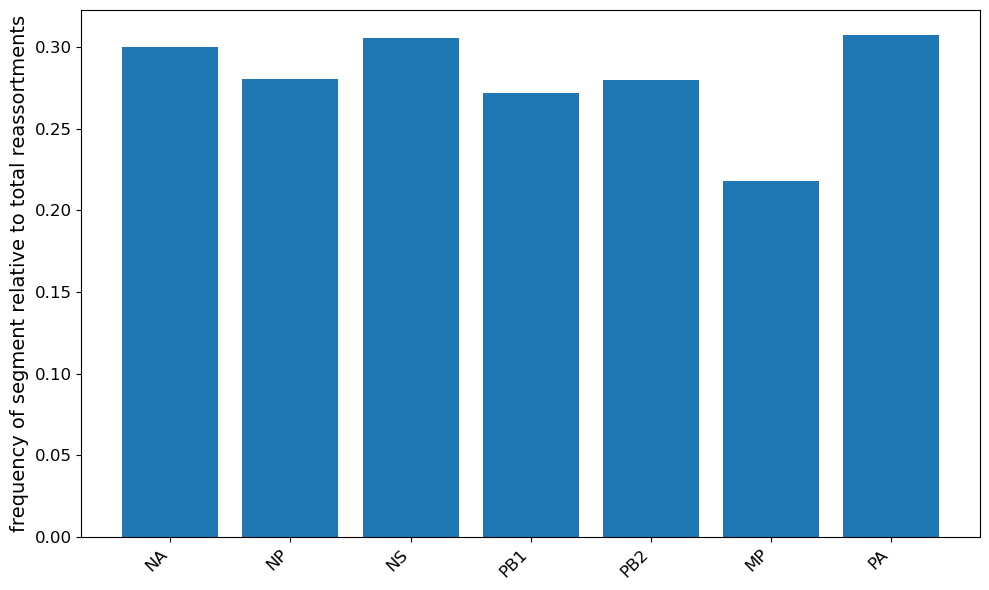

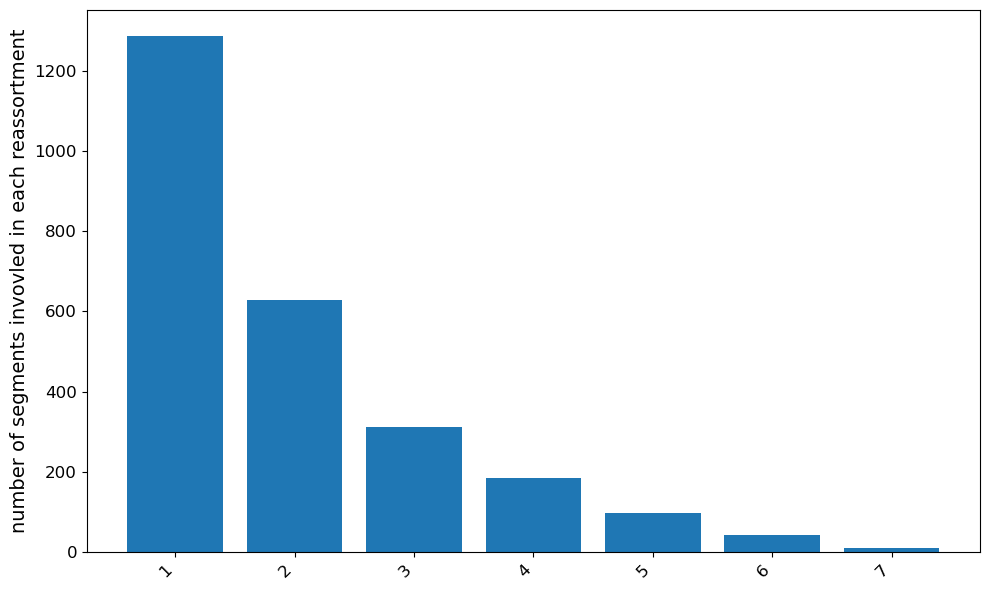

In [8]:
# segment count / total reassortments
counts = []
labels = []

for segment, count in gene_segment_counts.items():
    counts.append(count / reassortment_count)
    labels.append(segment)
                  
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)

plt.ylabel('frequency of segment relative to total reassortments', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig(f"{path}/plots/segment/segment-count-by-total-reassortment.pdf")


# number of segments invovled in each reassortment

counts = []
labels = []

for num_segments, count in num_segments_involved.items():
    counts.append(count)
    labels.append(num_segments)
                  
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)

plt.ylabel('number of segments invovled in each reassortment', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig(f"{path}/plots/segment/num-segments-in-reassortment.pdf")

(-1.0999999999891041,
 1.0999999997792378,
 -1.0999999967699803,
 1.0999999997146583)

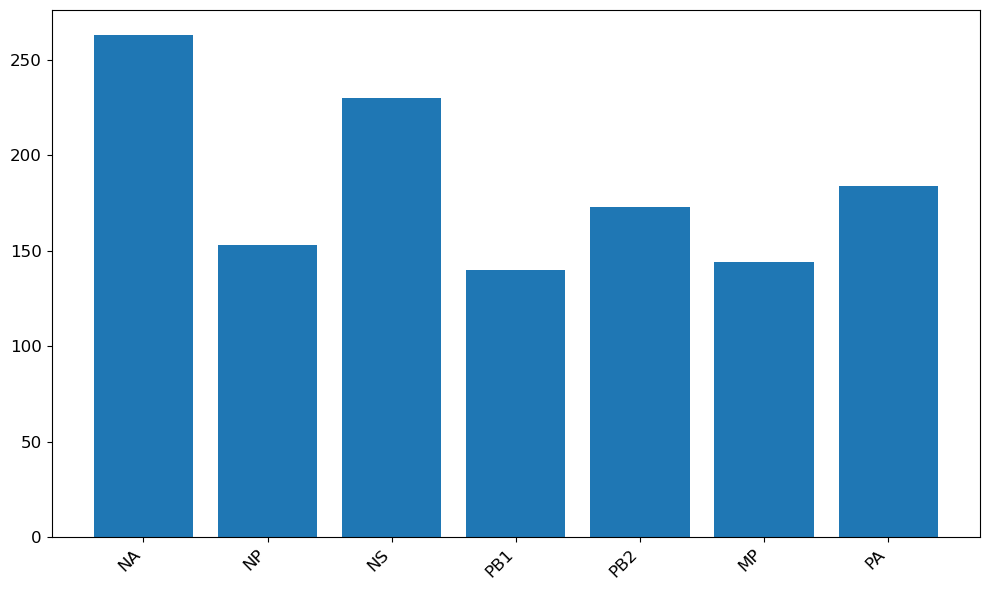

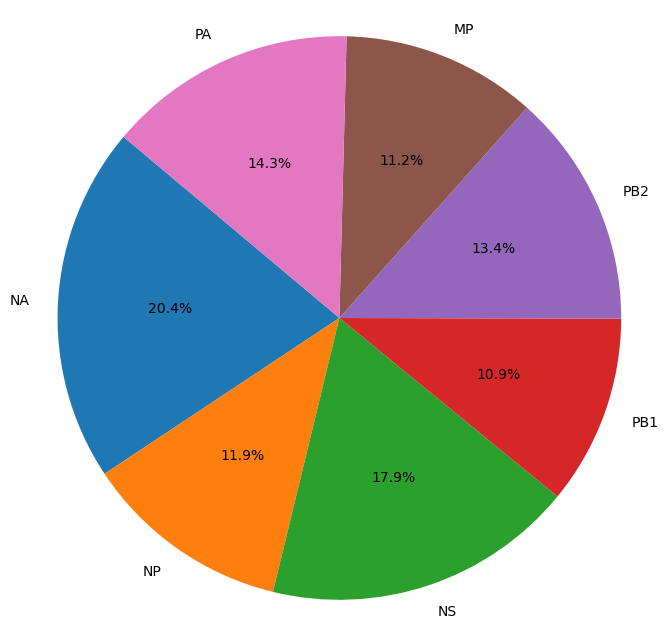

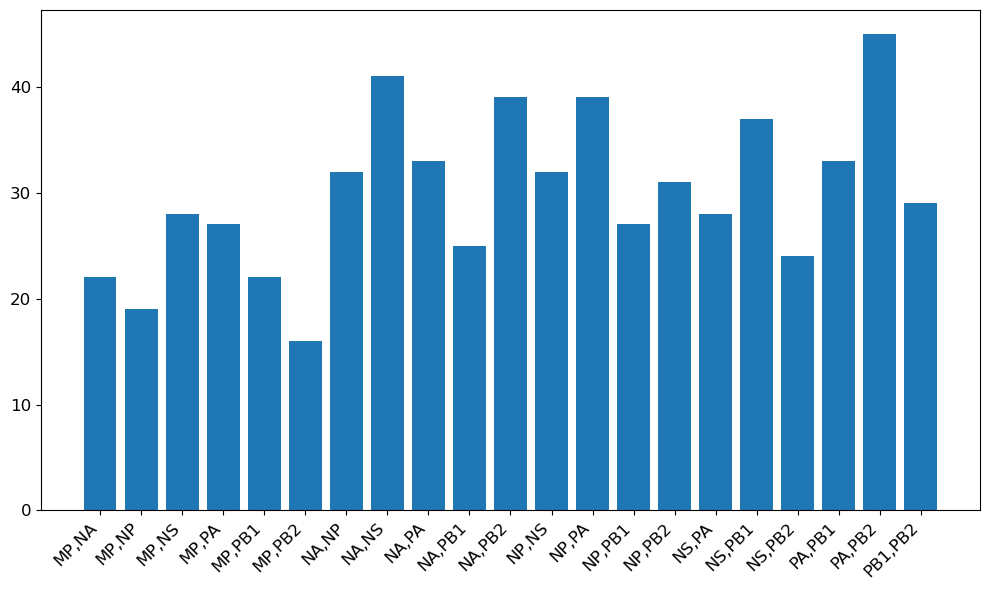

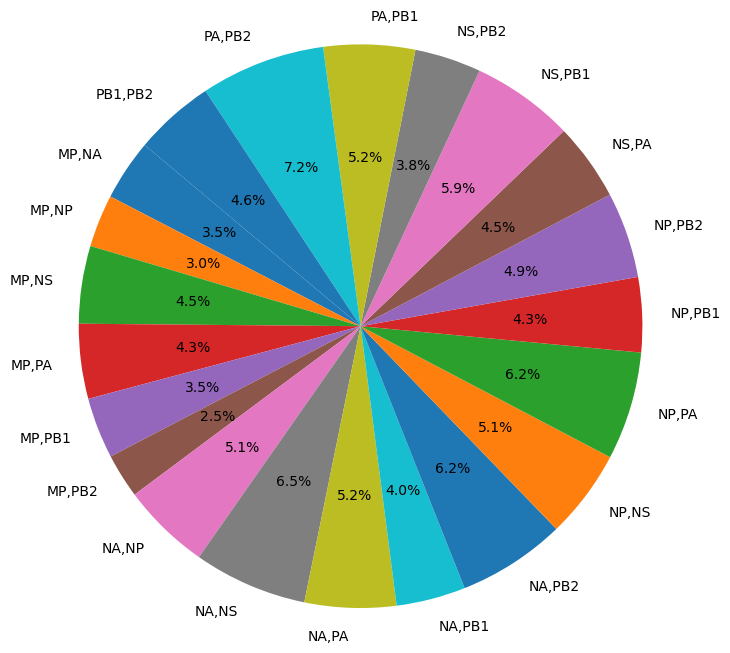

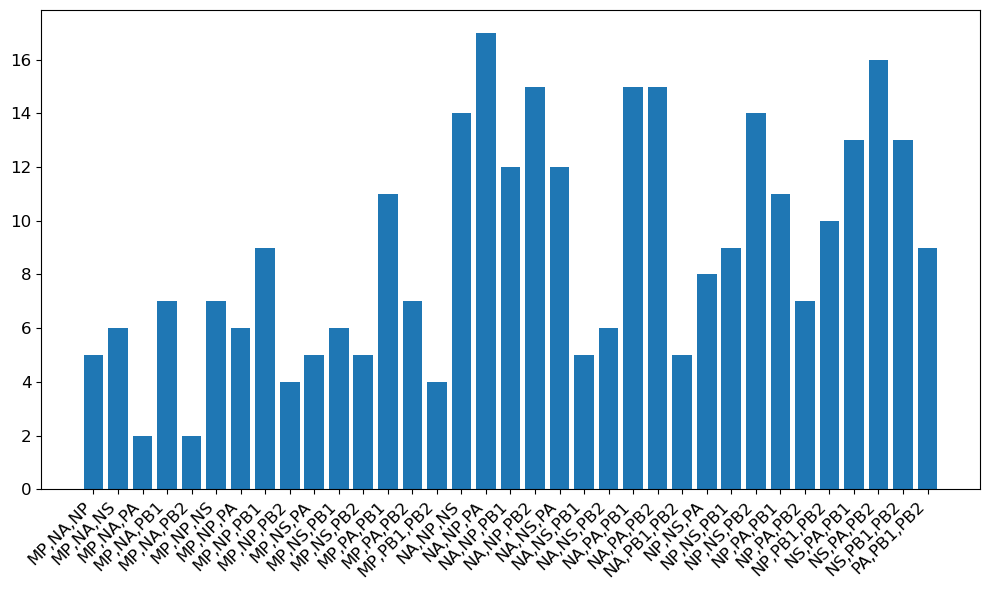

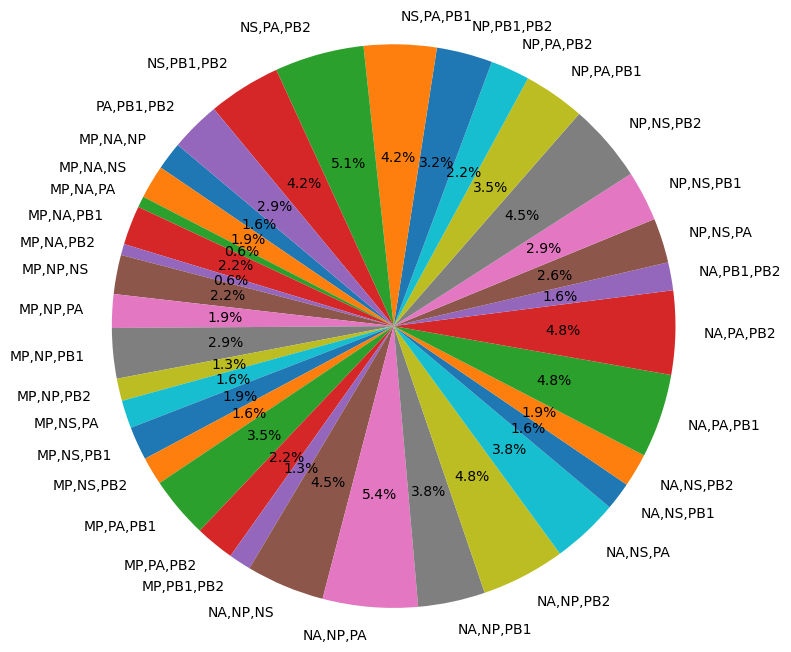

In [9]:
#plotting identity of segments in reassortments involving 1,2, or 3 segments

#one segment 

counts = []
labels = []

for segments, count in one_segment.items():
    counts.append(count)
    labels.append(segments)
                  
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig(f"{path}/plots/segment/one_segment.pdf")

percentages = [(count / total) * 100 for count in one_segment.values() if (count / total) * 100 > 0]
labels = [label for label, count in zip(labels, one_segment.values()) if (count / total) * 100 > 0]

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
# plt.savefig(f"{path}/plots/segment/one_segment_piechart.pdf")

#two seg

counts = []
labels = []

for seg_pairs, count in two_seg.items():
    counts.append(count)
    labels.append(','.join(seg_pairs))
                  
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig(f"{path}/plots/segment/two_segment.pdf")

percentages = [(count / total) * 100 for count in two_seg.values() if (count / total) * 100 > 0]
labels = [label for label, count in zip(labels, two_seg.values()) if (count / total) * 100 > 0]

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
# plt.savefig(f"{path}/plots/segment/two_segment_piechart.pdf")

#three seg

counts = []
labels = []

for seg_triplets, count in three_seg.items():
    counts.append(count)
    labels.append(','.join(seg_triplets))
                  
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig(f"{path}/plots/segment/three_segment.pdf")

percentages = [(count / total) * 100 for count in three_seg.values() if (count / total) * 100 > 0]
labels = [label for label, count in zip(labels, three_seg.values()) if (count / total) * 100 > 0]

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
# plt.savefig(f"{path}/plots/segment/three_segment_piechart.pdf")


**Step 6:**
network script

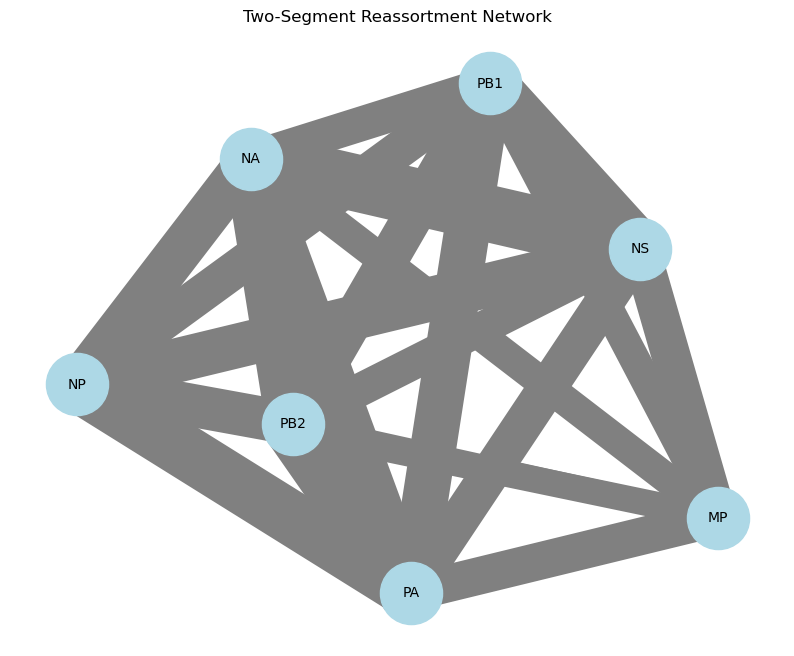

In [10]:
#two segment
G = nx.Graph()

gene_segments = ['NA', 'NP', 'NS', 'PB1', 'PB2', 'MP', 'PA']
G.add_nodes_from(gene_segments)

for segment_pair, count in two_seg.items():
    if count > 0:  # only add edges for segment pairs with at least one reassortment event
        G.add_edge(segment_pair[0], segment_pair[1], weight=count)

pos = nx.spring_layout(G)  

plt.figure(figsize=(10, 8))
edges = G.edges(data=True)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000)

scaling_factor = 1
# scaling_factor = 0.3 

# Draw edges with scaled thickness
nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[d['weight'] * scaling_factor for (_, _, d) in edges],
    edge_color='gray'
)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Two-Segment Reassortment Network")
plt.axis('off')
plt.show()


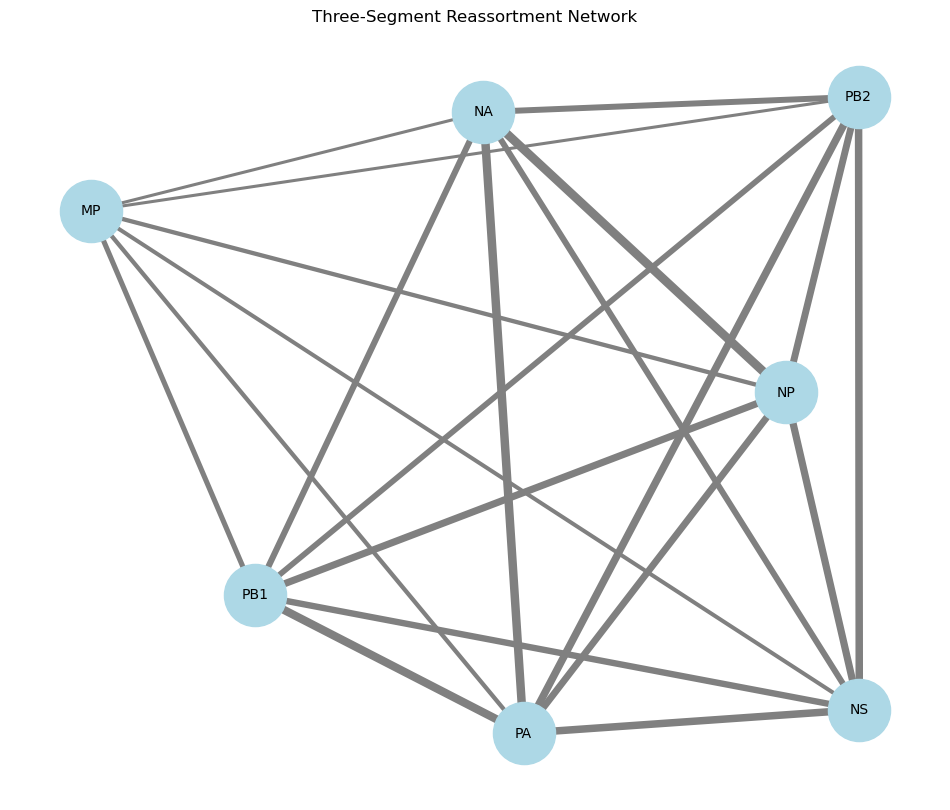

In [11]:
G = nx.Graph()

gene_segments = ['NA', 'NP', 'NS', 'PB1', 'PB2', 'MP', 'PA']
G.add_nodes_from(gene_segments)

for trio, count in three_seg.items():
    if count > 0:
        # for each trio, add an edge between each pair within the trio
        segment_combinations = itertools.combinations(trio, 2)
        for seg_pair in segment_combinations:
            if G.has_edge(*seg_pair):
                # if the edge already exists, increase its weight
                G[seg_pair[0]][seg_pair[1]]['weight'] += count
            else:
                # otherwise, add the edge with initial weight
                G.add_edge(seg_pair[0], seg_pair[1], weight=count)

pos = nx.spring_layout(G)  # Position nodes using a spring layout

plt.figure(figsize=(12, 10))

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000)

edges = G.edges(data=True)

# scaling_factor = 1 
scaling_factor = 0.1

nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[d['weight'] * scaling_factor for (_, _, d) in edges],
    edge_color='gray'
)


nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')

plt.title("Three-Segment Reassortment Network")
plt.show()


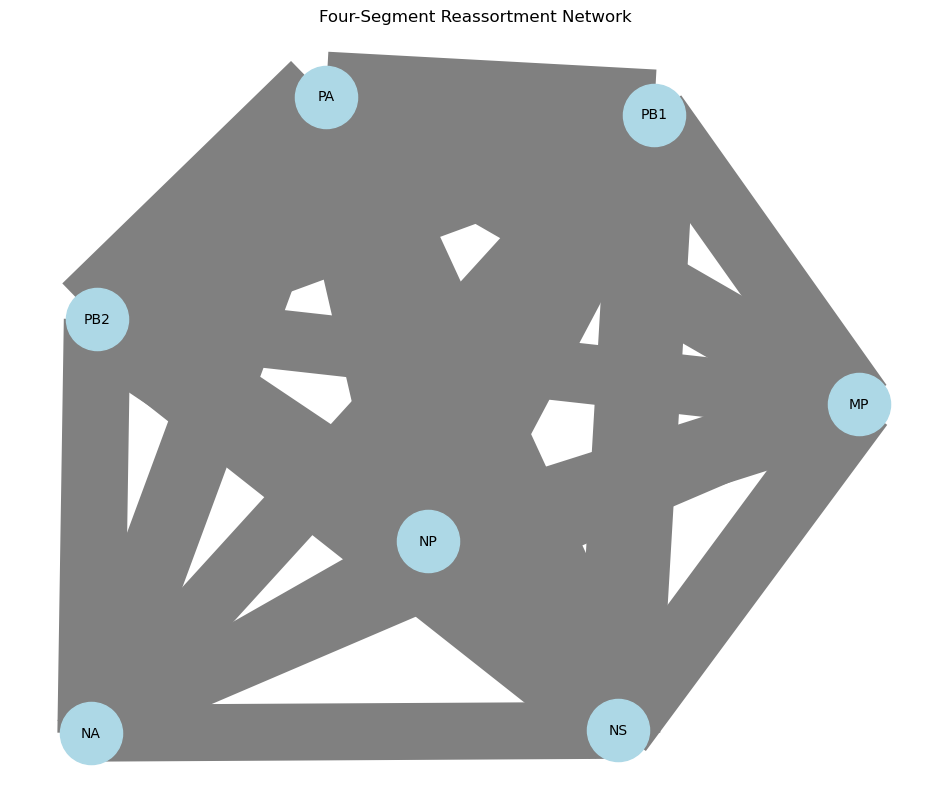

In [12]:
G = nx.Graph()

gene_segments = ['NA', 'NP', 'NS', 'PB1', 'PB2', 'MP', 'PA']
G.add_nodes_from(gene_segments)

for quad, count in four_seg.items():
    if count > 0:
        # for each trio, add an edge between each pair within the trio
        segment_combinations = itertools.combinations(quad, 2)
        for seg_pair in segment_combinations:
            if G.has_edge(*seg_pair):
                # if the edge already exists, increase its weight
                G[seg_pair[0]][seg_pair[1]]['weight'] += count
            else:
                # otherwise, add the edge with initial weight
                G.add_edge(seg_pair[0], seg_pair[1], weight=count)

pos = nx.spring_layout(G)  # Position nodes using a spring layout

plt.figure(figsize=(12, 10))

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000)

edges = G.edges(data=True)

scaling_factor = 1 
# scaling_factor = 0.3

nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[d['weight'] * scaling_factor for (_, _, d) in edges],
    edge_color='gray'
)


nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')

plt.title("Four-Segment Reassortment Network")
plt.show()


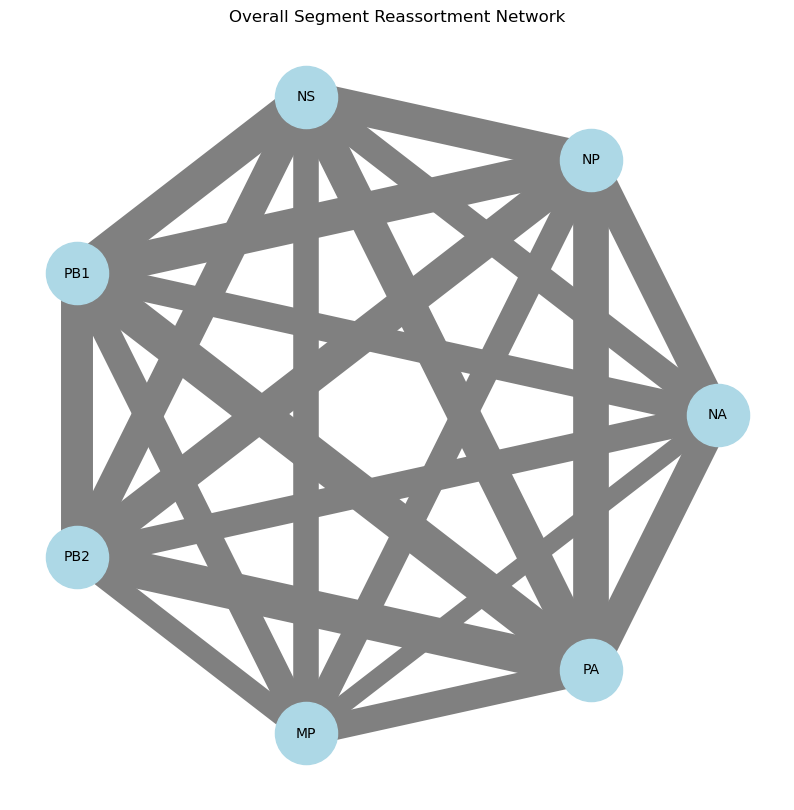

In [13]:
G = nx.Graph()

gene_segments = ['NA', 'NP', 'NS', 'PB1', 'PB2', 'MP', 'PA']
G.add_nodes_from(gene_segments)

unique_rea_event = set()

for k in mytree.Objects:

    if k.traits.get('is_reassorted'):

        reassortment_event = k.traits.get('rea')

        if reassortment_event not in unique_rea_event:
            unique_rea_event.add(reassortment_event)

            lst = reassortment_event.split('-')
            cleaned_segments = [seg.split('(')[0].replace('_', '') for seg in lst]
            
        
            reassorted_segments = k.traits['rea'].split('-')
            cleaned_segments = [seg.split('(')[0].replace('_', '') for seg in reassorted_segments]
            
            
            for seg_pair in itertools.combinations(cleaned_segments, 2):
                if G.has_edge(*seg_pair):
                    G[seg_pair[0]][seg_pair[1]]['weight'] += 1
                else:
                    G.add_edge(seg_pair[0], seg_pair[1], weight=1)
        
        elif reassortment_event in unique_rea_event:
            continue


pos = nx.circular_layout(G)

plt.figure(figsize=(10, 10))

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000)


edges = G.edges(data=True)

scaling_factor = 0.1

nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[d['weight'] * scaling_factor for (_, _, d) in edges],
    edge_color='gray'
)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')

plt.title("Overall Segment Reassortment Network")
plt.show()


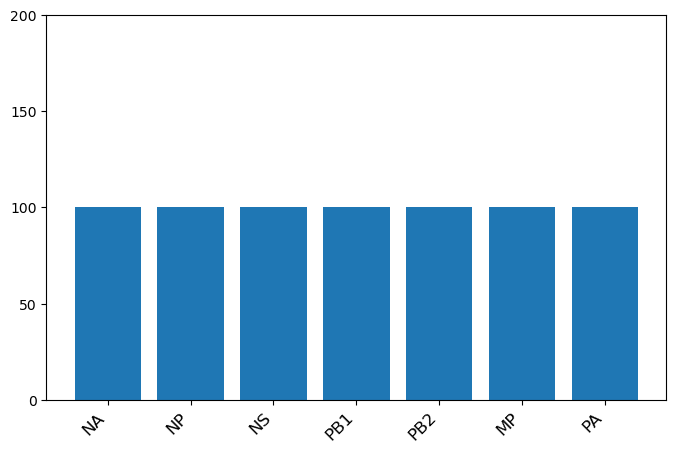

In [14]:
import matplotlib.pyplot as plt

# Data for the bar plot
segments = ['NA', 'NP', 'NS', 'PB1', 'PB2', 'MP', 'PA']
y_values = [100] * len(segments)

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(segments, y_values)

# Add labels and title
plt.ylim(0, 200)  # Set the range of the y-axis
plt.yticks([0, 50, 100, 150, 200])  # Specify the exact tick marks
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.show()
